In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fnmatch
import os
import re

In [4]:
def getElmerRes(folder_name, in_file_name):
    
    file_pre = in_file_name + '*'
    
    file_names = fnmatch.filter(os.listdir(folder_name), file_pre)

    file_name = [get_name for get_name in file_names if not('.names' in get_name)]

    matrix = np.empty((0,),float)

    for idx_fn in range(len(file_name)):

        with open('./' + folder_name + '/' + file_name[idx_fn], 'r') as f:
            res_file = f.read()

        pattern1 = '   ' # space patter used to delimit values
        pattern2 = '  ' # space patter used to delimit values
        spc_pattern = ' '
        brk_pattern = '\n'

        # There are different patterns, easier to convert them to a single space
        res_file = re.sub(pattern1, spc_pattern, res_file)
        res_file = re.sub(pattern2, spc_pattern, res_file)

        iter_ln_vector = re.finditer(brk_pattern, res_file) # ln -> line

        idx_ln = 0
        ini_str = 0

        # values = np.zeros((9,),float)

        for iter_ln_val in iter_ln_vector:
            end_str = iter_ln_val.start()
            # print(end_str)    
            str_ln = res_file[ini_str:end_str]
            # print(str_ln) # Here I am breaking the lines into strings
            ini_str = end_str + 1

            iter_vl_vector = re.finditer(spc_pattern, str_ln) # vl -> value
            
            str_vl_vec = str_ln.split()
            # print(float(str_vl_vec[0]))

            values = np.empty((0,),float)

            for idx_value in range(len(str_vl_vec)):
                # values[idx_value] = float(str_vl_vec[idx_value])
                values = np.append(values,float(str_vl_vec[idx_value]))
                # print(values.shape)
            
            # The matrix is created empty. So, its size can be used as a test so I don't need to specify it priorly. 
            matrix = values.reshape(1,len(str_vl_vec)) if matrix.size == 0 else np.append(matrix,values.reshape(1,len(str_vl_vec)),axis=0)
            
    return matrix # [matrix[:,3].argsort()]


def calcDistB(matrix):
    x = matrix[:,4]
    y = matrix[:,5]
    z = matrix[:,6]
    Bx = matrix[:,7]
    By = matrix[:,8]
    Bz = matrix[:,9]

    ef_dist = np.sqrt((x - x[0])**2 + (y - y[0])**2 + (z - z[0])**2)
    ef_absB = np.sqrt(Bx**2 + By**2 + Bz**2)

    return ef_dist, ef_absB

def calcDistB_cyl(matrix):
    r = matrix[:,4]
    th = matrix[:,5]
    z = matrix[:,6]
    Bx = matrix[:,7]
    By = matrix[:,8]
    Bz = matrix[:,9]

    ef_dist = np.sqrt((r*(th*np.pi/180) - r[0]*(th[0]*np.pi/180))**2)
    ef_absB = np.sqrt(Bx**2 + By**2 + Bz**2)


    return ef_dist, ef_absB

Ploting resutls

From Pavel PMSM Tutorial:

The air gap flux density can be easily obtained in ParaView. For this purpose first apply Cell Data To Point Data filter in the pipeline, which will convert vector data to scalar data on the points. And then, apply Plot On Intersection Curves filter. Where first select Slice Type as Sphere with radius of the middle of the air gap. And then, tick in the Line Series just Magnetic Flux Density_Magnitude.
File -> Save Data (in *.csv format)

In [41]:
# Reading data from Elmer / Paraview. 

pv_res = pd.read_csv('Bag_paraview.csv')

pv_x = np.array(pv_res['Points:0'])
pv_y = np.array(pv_res['Points:1'])
ef_dist = np.array(pv_res['arc_length']) #[30:1342]
pv_Bx = np.array(pv_res['magnetic flux density:0']) #[30:1342]
pv_By = np.array(pv_res['magnetic flux density:1']) #[30:1342]

ef_dist = ef_dist - ef_dist[0]
ef_absB = np.sqrt(pv_Bx**2 + pv_By**2)

Getting the results fom SaveData procedure

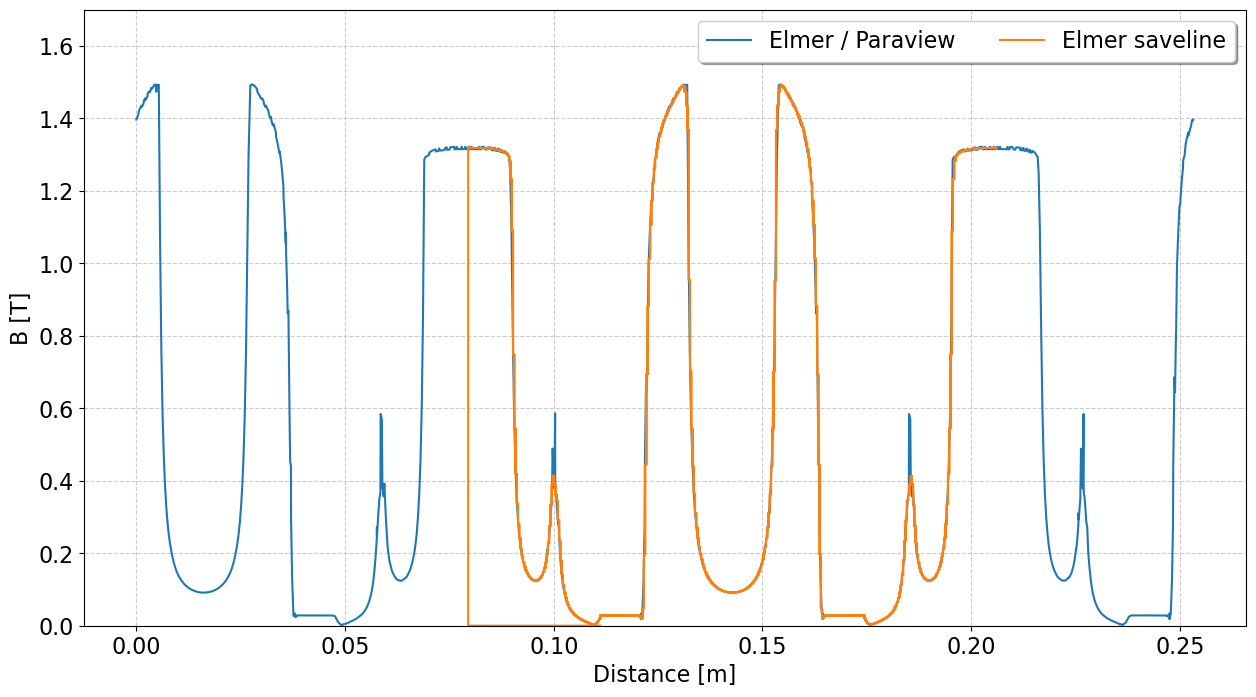

In [50]:
folder_name = 'results' # 'res_pmsm_nr' or 'res_pmsm'
file_name = 'lines.dat'

ef_res = getElmerRes(folder_name, file_name)
ef_dist_dat, ef_absB_dat = calcDistB_cyl(ef_res)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(ef_dist, ef_absB, label = 'Elmer / Paraview')
ax.plot(ef_dist_dat + 0.0795, ef_absB_dat, label = 'Elmer saveline')
# ax.plot(fm_dis*1e-3, fm_absB, label = 'FEMM')
ax.legend(fontsize = 16, ncol = 2, fancybox=True, shadow=True, loc = 'upper right')

# ax.set_title('Joint curve', fontsize = 16)s

ax.set_ylim(0,1.7)
ax.set_xlabel('Distance [m]', fontsize = 16)
ax.set_ylabel('B [T]', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.grid(color=(0.8, 0.8, 0.8), linestyle='--', linewidth=.8)